# Project Introduction: Resume Parser

- Intelligent Document Processing (IDP) is an advanced automation technology that transforms the way businesses handle documents. By leveraging artificial intelligence (AI), IDP systems can automatically read, understand, and process vast quantities of documents, extracting crucial data and feeding it into various business workflows. This technology is a significant leap from traditional Optical Character Recognition (OCR) as it not only digitizes text but also comprehends the context and structure of the information within documents.
- At its core, IDP is designed to tackle the challenge of processing unstructured and semi-structured data, which make up a large portion of business documents such as invoices, contracts, emails, and forms. By automating the extraction and interpretation of this data, IDP significantly reduces the need for manual data entry, leading to increased efficiency, higher accuracy, and substantial cost savings.
- **In this project we will try extracting skills using a predefined list of keywords. Count and plot the top 10 most common skills. Experiment with NER models (like spaCy) to automatically extract names, companies, degrees. Compare resumes against a sample job description for matching.**

# The Resume Dataset

## Getting the data

In [39]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("snehaanbhawal/resume-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'resume-dataset' dataset.
Path to dataset files: /kaggle/input/resume-dataset


## OCR and Text Extraction

In [40]:
pip install PyMuPDF

In [41]:
pip install pytesseract

In [42]:
import os, fitz
from PIL import Image
import pytesseract

resume_texts = {}
resume_folder = "/kaggle/input/resume-dataset/data/data/BPO"

for file in os.listdir(resume_folder):
    if file.endswith(".pdf"):
        doc = fitz.open(os.path.join(resume_folder, file))
        text = ""
        for page in doc:
            page_text = page.get_text()
            if page_text.strip():
                text += page_text
            else:
                pix = page.get_pixmap()
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
                text += pytesseract.image_to_string(img)
        resume_texts[file] = text

## Skill Extraction via Keyword Matching

In [43]:
import re

def extract_education_regex(text):
    patterns = [
        r"(Bachelor(?:'s)?\s(?:of\s)?[A-Za-z\s]+)",
        r"(Master(?:'s)?\s(?:of\s)?[A-Za-z\s]+)",
        r"(Ph\.?D|Doctorate)",
        r"(MBA|B\.?Com|M\.?Com|B\.?Sc|M\.?Sc|B\.?Tech|M\.?Tech)",
        r"(Diploma\s(?:in\s)?[A-Za-z\s]+)",
        r"(High School|Intermediate|Senior Secondary)",
        r"(CA|CPA|ICWA|ACCA)"
    ]
    education = []
    for pattern in patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        education.extend(matches)
    return list(set(education))


In [44]:
import spacy

nlp = spacy.load("en_core_web_sm")

def extract_education_ner(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == "EDUCATION"]

In [45]:
def extract_education(text):
    regex_edu = extract_education_regex(text)
    ner_edu = extract_education_ner(text)
    return list(set(regex_edu + ner_edu))

In [46]:
resume_education = {file: extract_education(text) for file, text in resume_texts.items()}

## Count and Plot Education mentions

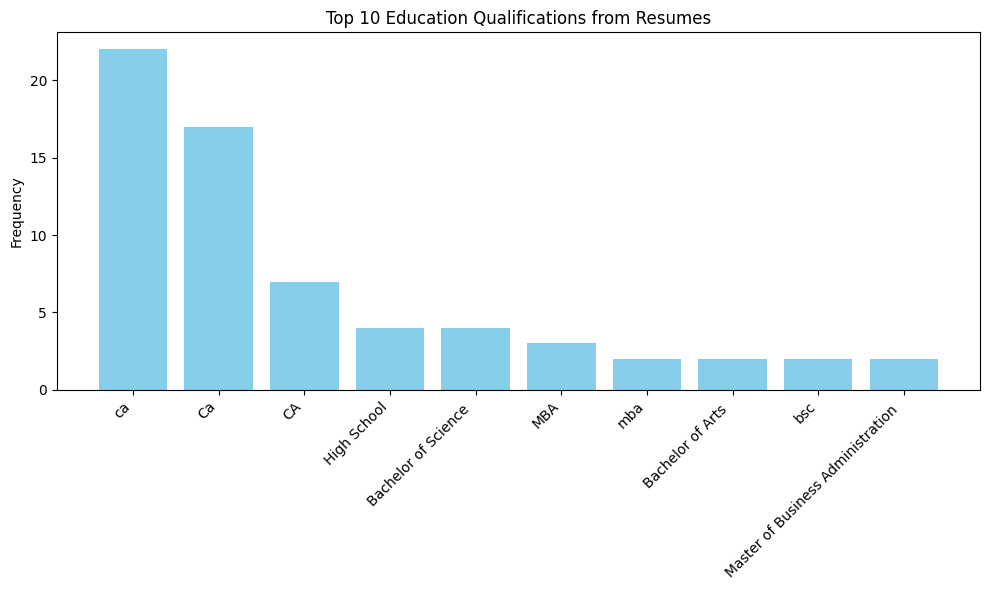

In [47]:
from collections import Counter

# Flatten all education mentions across resumes
all_education = [edu for edus in resume_education.values() for edu in edus]

# Count frequency
education_counts = Counter(all_education)

top_education = education_counts.most_common(10)
import matplotlib.pyplot as plt

if top_education:
    labels, counts = zip(*top_education)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.title("Top 10 Education Qualifications from Resumes")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()
else:
    print("No education data found to plot.")


In [48]:
! pip install pytesseract pillow

## Convert PDF to Image

In [49]:
!pip install pdf2image
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
poppler-utils is already the newest version (22.02.0-2ubuntu0.10).
0 upgraded, 0 newly installed, 0 to remove and 38 not upgraded.


Successfully converted the PDF into 3 pages (images).

Displaying the first page:


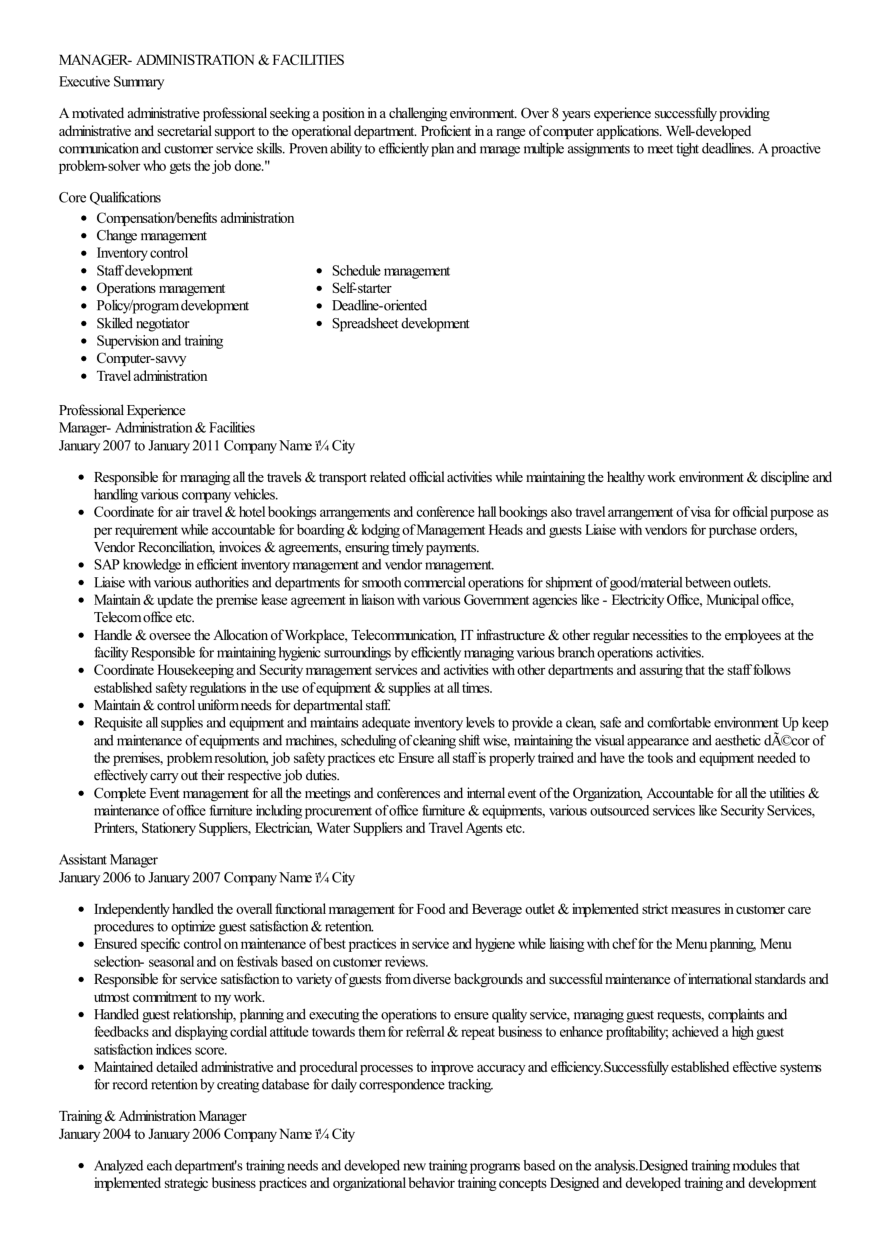

In [50]:
from PIL import Image
import pytesseract
import time
import os
from pdf2image import convert_from_path

pdf_filename = "11183737.pdf"
pdf_path = os.path.join("/kaggle/input/resume-dataset/data/data/BPO", pdf_filename)
# PDF to a list of PIL Image
try:
    images = convert_from_path(pdf_path)
    print(f"Successfully converted the PDF into {len(images)} pages (images).")

    # first page
    if images:
        print("\nDisplaying the first page:")
        plt.figure(figsize=(12, 16))
        plt.imshow(images[0])
        plt.axis('off')
        plt.show()
except Exception as e:
    print(f"An error occurred: {e}")
    print("Please ensure the file path is correct and the libraries were installed successfully.")



## Image Pre-processing

In [51]:
! pip install opencv-python matplotlib numpy

Preprocessing each page...
Successfully preprocessed 3 pages.

Displaying the preprocessed first page:


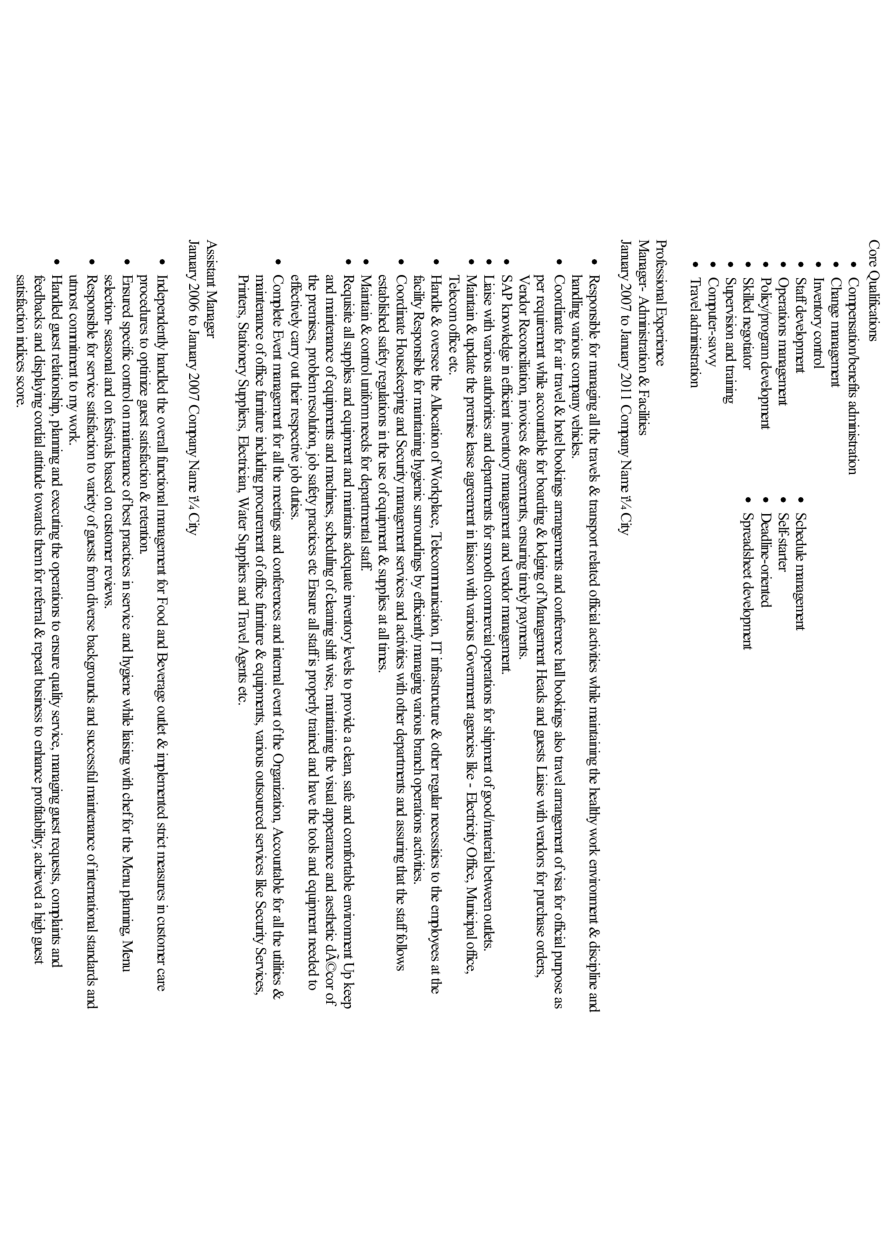

In [52]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image # Import Image for type hinting

def preprocess(image: Image.Image) -> np.ndarray:
    """
    Applies a series of preprocessing steps to an image for improved OCR accuracy.

    Args:
        image: A PIL Image object.

    Returns:
        A NumPy array representing the preprocessed image.
    """
    # Convert PIL Image to OpenCV format (NumPy array)
    # OpenCV uses BGR color order, PIL uses RGB, so we reverse the color channels
    open_cv_image = np.array(image)
    open_cv_image = open_cv_image[:, :, ::-1].copy()

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

    # Binarize the image using adaptive thresholding and invert colors
    # This helps in separating text from the background
    binarized_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, 11, 4
    )

    # Skew Correction: Detect and correct rotation in the image
    # Find non-zero pixels (which represent text/lines in the binarized image)
    coords = cv2.findNonZero(binarized_image)
    if coords is not None: # Check if any contours were found
        # Find the minimum area rectangle enclosing the non-zero pixels
        rect = cv2.minAreaRect(coords)
        angle = rect[-1] # Get the angle of the rectangle

        # Adjust the angle based on the orientation of the rectangle
        if angle < -45:
            angle = -(90 + angle)
        else:
            angle = -angle

        # Get the dimensions of the image
        (h, w) = gray_image.shape[:2]
        center = (w // 2, h // 2) # Define the center of the image

        # Get the rotation matrix
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Apply the rotation to deskew the image
        deskewed_image = cv2.warpAffine(
            gray_image, M, (w, h),
            flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE # Use replicated border to fill empty areas
        )
    else:
        # If no contours are found, return the original grayscale image (or handle as appropriate)
        deskewed_image = gray_image
        print("No contours found for skew correction. Returning original grayscale image.")


    return deskewed_image

print("Preprocessing each page...")
preprocessed_images = []
# Assuming 'images' is a list of PIL Images from previous steps
if 'images' in locals() and images:
    for img in images:
        processed = preprocess(img)
        preprocessed_images.append(processed)

    print(f"Successfully preprocessed {len(preprocessed_images)} pages.")

    # Display the first preprocessed page
    if preprocessed_images:
        print("\nDisplaying the preprocessed first page:")
        plt.figure(figsize=(12, 16))
        plt.imshow(preprocessed_images[0], cmap='gray') # Use cmap='gray' for grayscale images
        plt.axis('off')
        plt.show()
else:
    print("No images found.")

## Prompt template for resume extraction

In [53]:
resume_prompt_template = """
You are an intelligent document parser. Your task is to extract structured information from resume text that has been extracted via OCR or PDF parsing.

The text may contain formatting issues, typos, or inconsistent structure. Use your best judgment to infer correct information where possible, but do NOT fabricate details.

Return the result strictly in the following JSON format. If any field is missing or unclear, return `null` for that field.

Extract the following:
- name: Full name of the applicant
- email: Email address
- phone: Phone number
- skills: List of key skills (e.g., Excel, Tally, Financial Reporting)
- experience: List of job experiences, each as an object with "company", "role", and "duration"
- education: List of educational qualifications, each as an object with "degree", "institution", and "year"

Format:
{{
  "name": "Full Name" or null,
  "email": "email@example.com" or null,
  "phone": "+91-XXXXXXXXXX" or null,
  "skills": ["Skill1", "Skill2", ...],
  "experience": [
    {{"company": "Company Name", "role": "Job Title", "duration": "Jan 2020 - Dec 2022"}},
    ...
  ],
  "education": [
    {{"degree": "Bachelor of Commerce", "institution": "Delhi University", "year": "2019"}},
    ...
  ]
}}

Resume Text:
\"\"\"{resume_text}\"\"\"
"""



## Information Extraction

In [54]:
pip install --upgrade --quiet google-generativeai

In [55]:
import google.generativeai as genai
from google.colab import userdata
import json
genai.configure(api_key=userdata.get('API_KEY'))
from PIL import Image
import json
import time

In [56]:

import pytesseract
from PIL import Image

print("Extracting text from all preprocessed pages...")

full_text = ""
for image_array in preprocessed_images:

    pil_image = Image.fromarray(image_array)
    text = pytesseract.image_to_string(pil_image)

    full_text += text + "\n\n--- Page Break ---\n\n"

print("Text extraction complete!")

#first 1000 characters
print("\nStart of Extracted Text (First 1000 Chars)")
print(full_text[:1000])
print("...")
print(" End of Preview ")

Extracting text from all preprocessed pages...
Text extraction complete!

Start of Extracted Text (First 1000 Chars)
Core Qualifications

Compensation/benefits administration

Change management

Inventory control

Staff development © Schedule management
Operations management ¢ Selfstarter
Policy/program development ¢ Deadline-oriented

Skilled negotiator ¢ Spreadsheet development
Supervision and training

Computer-sawvy

Travel administration

Professional Experience
Manager- Administration & Facilities
January 2007 to January 2011 Company Name i City

Responsible for managing all the travels & transport related official activities while maintaining the healthy work environment & discipline and
handling various company vehicles.

Coordinate for air travel & hotel bookings arrangements and conference hall bookings also travel arrangement of visa for official purpose as
per requirement while accountable for boarding & lodging of Management Heads and guests Liaise with vendors for purchas

In [57]:
# To check available GenAI models
for m in genai.list_models():
    print(m.name)

models/embedding-gecko-001
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp-1219
models/gemini-2.5-flash-preview-tts
models/gemini-2.5-pro-preview-tts
models/learnlm-2.0-flash-experimental
models/gemma-3-1b-it
models/gemma-3-4b-it
models/gemma-3-12b-it
models/gemma-3-27b-it
models/gemma-3n-e4b-it
mo

In [58]:
def extract_info_with_gemini_from_text(text_from_resume):
    """
    Uses Gemini to extract structured information from a text prompt.
    """
    model = genai.GenerativeModel('gemini-2.0-flash')
    prompt = resume_prompt_template.format(resume_text=text_from_resume)

    response = model.generate_content(prompt)

    # Try to get model text safely
    if hasattr(response, "text"):
        model_text = response.text
    else:
        # fallback for new API structure
        try:
            model_text = response.candidates[0].content.parts[0].text
        except Exception as e:
            print("Could not extract text from Gemini response:", e)
            print(response)
            return None

    try:
        cleaned_text = model_text.replace('```json', '').replace('```', '').strip()
        start_index = cleaned_text.find('{')
        end_index = cleaned_text.rfind('}') + 1

        if start_index == -1 or end_index == 0:
            print("!! ERROR: Could not find a JSON object in the model's response. !!")
            print(f"   Raw response was:\n---\n{model_text}\n---")
            return None

        json_string = cleaned_text[start_index:end_index]
        return json.loads(json_string)

    except (json.JSONDecodeError, IndexError) as e:
        print(f"\n!! FAILED TO PARSE JSON !!")
        print(f"   Error: {e}")
        print(f"   Raw response was:\n \n{model_text}\n")
        return None


In [59]:
print("Calling Gemini now...")
extracted_data = extract_info_with_gemini_from_text(full_text)
print("Function finished.")

if extracted_data:
    print("\nExtracted Information:")
    print(json.dumps(extracted_data, indent=4))
else:
    print("\nNo extracted data returned.")


Calling Gemini now...
Function finished.

Extracted Information:
{
    "name": null,
    "email": null,
    "phone": null,
    "skills": [
        "Compensation/benefits administration",
        "Change management",
        "Inventory control",
        "Staff development",
        "Schedule management",
        "Operations management",
        "Selfstarter",
        "Policy/program development",
        "Deadline-oriented",
        "Skilled negotiator",
        "Spreadsheet development",
        "Supervision and training",
        "Computer-sawvy",
        "Travel administration",
        "SAP knowledge",
        "ecommerce",
        "Proven written and oral communication skills",
        "Proficient in managing business correspondence",
        "Ability to organize personal work priorities",
        "Knowledge of filing and updating records",
        "Ability to make travel and accommodation arrangements",
        "Light bookkeeping knowledge",
        "General office procedural knowh

# Conclusion

**In this project, we developed an Intelligent Resume Parser by combining traditional text processing techniques with modern AI models. Starting with raw resumes in PDF format, we implemented a complete pipeline that included:**

- Data ingestion from Kaggle’s Resume Dataset.

- OCR and text extraction using PyMuPDF, Tesseract, and pdf2image, enhanced by preprocessing with OpenCV for improved accuracy on scanned resumes.

- Skill and education extraction using both regex-based patterns and NER models (spaCy), with visualization of the most common qualifications across resumes.

- Prompt engineering for structured extraction, where we designed a JSON-based schema to consistently capture candidate details such as name, email, phone number, skills, experiences, and education.

- Experimentation with Gemini API, demonstrating how large language models can structure messy, unstructured resume text into machine-readable formats.

- The results show that combining deterministic methods (regex, keyword matching) with generative AI models provides the best balance between accuracy and flexibility. Regex rules are reliable for common degrees and keywords, while LLMs excel at interpreting context, inferring structure, and filling gaps in noisy OCR outputs.


- This hybrid approach highlights the power of Intelligent Document Processing (IDP) in real-world business use cases. Automating resume parsing not only reduces manual effort but also enables faster candidate shortlisting and richer insights when matched against job descriptions.